<a href="https://colab.research.google.com/github/jimin-fundamental/ML-2024-fall/blob/main/%5B%EB%B2%A0%EC%9D%B4%EC%8A%A4%EB%9D%BC%EC%9D%B8%5D_%EB%8D%B0%EC%9D%B4%EC%BD%98_%EA%B8%B0%EC%B4%88_%EB%B2%A0%EC%9D%B4%EC%8A%A4%EB%9D%BC%EC%9D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. 라이브러리 불러오기**

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
import numpy as np
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os

In [23]:


# Print the current working directory
print("Current working directory:", os.getcwd())

Current working directory: /content/drive/My Drive/Colab Notebooks/ML_TeamProject


In [24]:
cd MyDrive/Colab Notebooks/ML_TeamProject

[Errno 2] No such file or directory: 'MyDrive/Colab Notebooks/ML_TeamProject'
/content/drive/MyDrive/Colab Notebooks/ML_TeamProject


# **2. 데이터 불러오기 및 간단 EDA**

In [25]:
train=pd.read_csv('train.csv') #/content/drive/MyDrive/Colab Notebooks/ML_TeamProject/test.csv
test=pd.read_csv('test.csv')
submission=pd.read_csv('sample_submission.csv')
#주의: baseline에서는 validation_sample을 사용하지 않았습니다.

In [26]:
print(train.shape, test.shape, submission.shape)

(472972, 3) (1418916, 2) (1418916, 2)


In [27]:
train.head()

,id,level,full_log
0,0,0,"Sep 24 10:02:22 localhost kibana: {""type"":""err..."
1,1,0,Feb 8 16:21:00 localhost logstash: [2021-02-0...
2,2,0,"Jan 13 01:50:40 localhost kibana: {""type"":""err..."
3,3,0,"Jan 4 10:18:31 localhost kibana: {""type"":""err..."
4,4,1,type=SYSCALL msg=audit(1603094402.016:52981): ...


In [28]:
#test는 level값이 없습니다
test.head()

,id,full_log
0,1000000,"Feb 8 15:47:26 localhost kibana: {""type"":""err..."
1,1000001,"Sep 24 03:46:39 localhost kibana: {""type"":""err..."
2,1000002,type=SYSCALL msg=audit(1611888200.428:210563):...
3,1000003,"Jan 18 11:24:06 localhost kibana: {""type"":""err..."
4,1000004,type=SYSCALL msg=audit(1603081202.050:46851): ...


<Axes: >

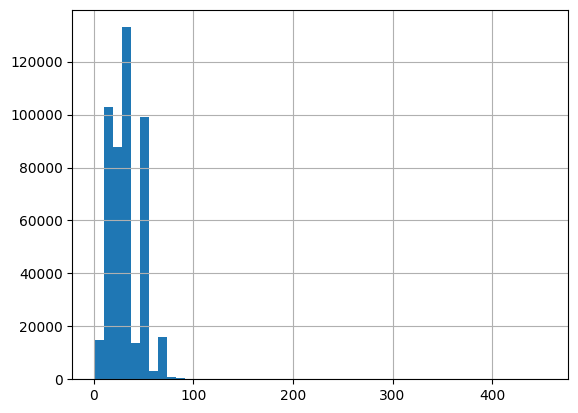

In [29]:
#train full_log의 길이 확인
train['full_log'].str.split(' ').str.len().hist(bins=50)

In [30]:
#train level별 값 확인
train['level'].value_counts()

,count
level,
0,334065
1,132517
3,4141
5,2219
2,12
4,10
6,8


# **3. 데이터 전처리**

In [31]:
#full_log에서 숫자는 마스킹 처리
train['full_log']=train['full_log'].str.replace(r'[0-9]', '<num>')
test['full_log']=test['full_log'].str.replace(r'[0-9]', '<num>')

In [32]:
#train['full_log'] => train_text로 list
#train['level']=> train_level로 array
train_text=list(train['full_log'])
train_level=np.array(train['level'])

In [33]:
#CountVectorizer로 벡터화
from sklearn.feature_extraction.text import CountVectorizer
vectorizer=CountVectorizer(analyzer="word", max_features=10000)

train_features=vectorizer.fit_transform(train_text)

In [34]:
train_features

<472972x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 21342499 stored elements in Compressed Sparse Row format>

# **4. 모델링**

In [35]:
#훈련 데이터 셋과 검증 데이터 셋으로 분리
TEST_SIZE=0.2
RANDOM_SEED=42

train_x, eval_x, train_y, eval_y=train_test_split(train_features, train_level, test_size=TEST_SIZE, random_state=RANDOM_SEED)

In [ ]:
#랜덤포레스트로 모델링
from sklearn.ensemble import RandomForestClassifier

forest=RandomForestClassifier(n_estimators=100)

forest.fit(train_x, train_y)

In [ ]:
#모델 검증
forest.score(eval_x, eval_y)

In [ ]:
#crosstab으로 확인
pred=forest.predict(eval_x)
crosstab = pd.crosstab(eval_y, pred, rownames=['real'], colnames=['pred'])
crosstab

+ 새로운 위험요소에 대한 가정 추가
+ => 예측치의 예측 확률이 0.90이하인 경우, 즉 확신이 없을 경우 이상치로 판단

In [ ]:
preds=forest.predict(eval_x)
probas=forest.predict_proba(eval_x)
print(preds.shape)
print(probas.shape)

In [ ]:
preds[np.where(np.max(probas, axis=1)<0.90)]=7
new_crosstab = pd.crosstab(eval_y, preds, rownames=['real'], colnames=['pred'])
new_crosstab

# **5. 예측**

In [ ]:
#test 데이터 전처리
test_text=list(test['full_log'])
ids=list(test['id'])

In [ ]:
#test 데이터 vectorizer
#주의: fit_transform의 경우 data leakage에 위반될 수 있습니다
test_features=vectorizer.transform(test_text)

In [ ]:
results=forest.predict(test_features)
results_proba=forest.predict_proba(test_features)
results[np.where(np.max(results_proba, axis=1) < 0.9)] = 7

In [ ]:
submission['level']=results

In [ ]:
submission

In [ ]:
submission.to_csv('baseline_submission.csv', index=False)